## Importing Dependencies

In [1]:
import os
import sys
import cv2
import numpy as np
import matplotlib.pyplot as plt
from textwrap import wrap

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import datasets, layers, models

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

from keras.models import Sequential,load_model,Model
from keras.layers import Conv2D,MaxPool2D,AveragePooling2D,Dense,Flatten,ZeroPadding2D,BatchNormalization,Activation,Add,Input,Dropout,GlobalAveragePooling2D
from keras.optimizers import SGD
from keras.initializers import glorot_uniform
from keras.preprocessing.image import ImageDataGenerator


In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS=3
EPOCHS=20

## Importing Dataset

In [3]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "Dataset",
    shuffle=True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 1336 files belonging to 3 classes.


In [4]:
class_names=dataset.class_names
class_names

['Early blight', 'Healthy', 'Late blight']

In [5]:
len(dataset)

42

In [6]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[1 2 2 1 1 0 0 1 0 0 0 2 2 2 0 1 1 0 2 0 1 2 0 0 2 0 0 2 0 0 1 0]


## Visualizing Dataset

In [7]:
plt.figure(figsize=(14, 14))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

## Train Test Split

In [8]:
train_size = 0.8
len(dataset)*train_size

33.6

In [9]:
train_ds = dataset.take(33)
len(train_ds)

33

In [10]:
test_ds = dataset.skip(33)
len(test_ds)

9

In [11]:
val_size=0.10
len(dataset)*val_size

4.2

In [12]:
val_ds = test_ds.take(4)
len(val_ds)

4

In [13]:
test_ds = test_ds.skip(4)
len(test_ds)

5

In [14]:
#train data 80%, Test data 10%, Validation 10%
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [15]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [16]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

## General Preprocess and Augmentation

In [17]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [18]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [19]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

## Building The Model

Staring from Basic few layer CNN Architecture to Multiple layers CNN Model with Batch Normalization And then will compare the proposed best CNN with PreBuild CNN Models (Transfer Learning Models)

## CNN Model Architecture: 01

CNN with 4 layers of convulation+Pooling layers and dense with unit size of 512. The CNN is a stacking of alternating Conv2D with Relu as an activation function and MaxPooling2D layers. Input of size 256 x 256, and immediately before the Flatten layer, will end up with feature maps of size 14 x 14. 

In [20]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model_01 = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(128,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(256,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model_01.build(input_shape=input_shape)

In [21]:
model_01.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 128)        

In [22]:
model_01.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [23]:
history_01 = model_01.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/20
33/33 [==============================] - 126s 4s/step - loss: 1.1447 - accuracy: 0.4129 - val_loss: 0.9725 - val_accuracy: 0.5859
Epoch 2/20
33/33 [==============================] - 119s 4s/step - loss: 0.7720 - accuracy: 0.6297 - val_loss: 1.0371 - val_accuracy: 0.6328
Epoch 3/20
33/33 [==============================] - 117s 4s/step - loss: 0.5690 - accuracy: 0.7661 - val_loss: 0.7928 - val_accuracy: 0.7578
Epoch 4/20
33/33 [==============================] - 118s 4s/step - loss: 0.4600 - accuracy: 0.8153 - val_loss: 0.4255 - val_accuracy: 0.8594
Epoch 5/20
33/33 [==============================] - 112s 3s/step - loss: 0.4573 - accuracy: 0.8286 - val_loss: 0.3682 - val_accuracy: 0.8438
Epoch 6/20
33/33 [==============================] - 100s 3s/step - loss: 0.3555 - accuracy: 0.8589 - val_loss: 0.3130 - val_accuracy: 0.8594
Epoch 7/20
33/33 [==============================] - 87s 3s/step - loss: 0.3307 - accuracy: 0.8561 - val_loss: 0.3256 - val_accuracy: 0.8672
Epoch 8/20
33/

In [24]:
scores_01 = model_01.evaluate(test_ds)

5/5 [==============================] - 5s 649ms/step - loss: 0.1615 - accuracy: 0.9312


## Plotting the Accuracy of Model 01

In [25]:
acc_01 = history_01.history['accuracy']
val_acc_01 = history_01.history['val_accuracy']

loss_01 = history_01.history['loss']
val_loss_01 = history_01.history['val_loss']

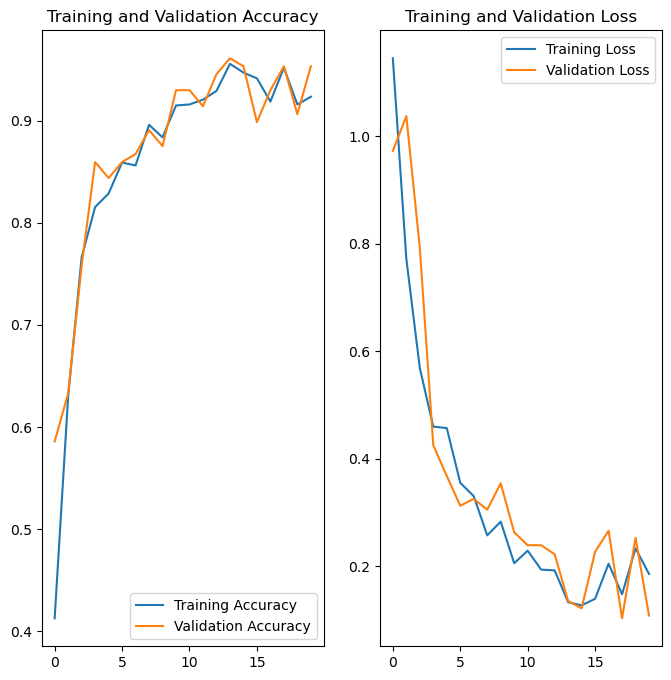

In [26]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc_01, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc_01, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss_01, label='Training Loss')
plt.plot(range(EPOCHS), val_loss_01, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [27]:
cnn_acc_01=scores_01[1]*100
print(f"Test Accuracy: ",cnn_acc_01)

Test Accuracy:  93.12499761581421


In [28]:
import itertools
from sklearn.metrics import precision_score, accuracy_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

In [29]:
labels = []
predictions = []
for x,y in test_ds:
    labels.append(list(y.numpy()))
    predictions.append(tf.argmax(model_01.predict(x),1).numpy())

1/1 [==============================] - 1s 773ms/step


In [30]:
predictions = list(itertools.chain.from_iterable(predictions))
labels = list(itertools.chain.from_iterable(labels))

In [31]:
print("Train Accuracy  : {:.2f} %".format(history_01.history['accuracy'][-1]*100))
print("Test Accuracy   : {:.2f} %".format(accuracy_score(labels, predictions) * 100))
print("Precision Score : {:.2f} %".format(precision_score(labels, predictions, average='micro') * 100))
print("Recall Score    : {:.2f} %".format(recall_score(labels, predictions, average='micro') * 100))

Train Accuracy  : 92.33 %
Test Accuracy   : 93.12 %
Precision Score : 93.12 %
Recall Score    : 93.12 %


<Figure size 800x500 with 0 Axes>

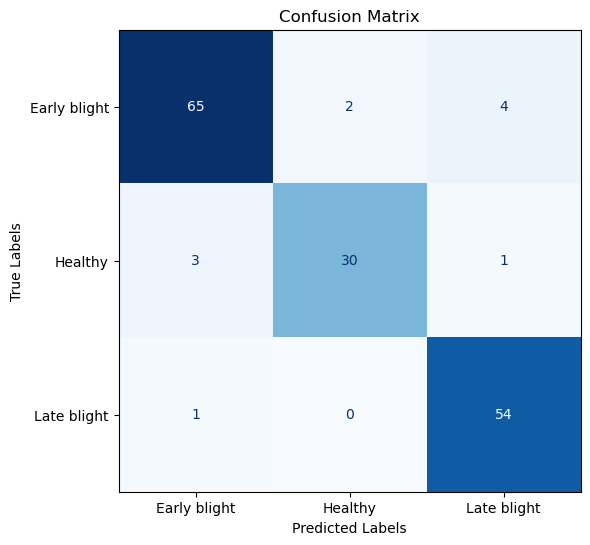

In [32]:
plt.figure(figsize= (8,5))
cm_plot_labels = ['Early blight', 'Healthy', 'Late blight']
cm = confusion_matrix(labels, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=cm_plot_labels)
fig, ax = plt.subplots(figsize=(6,6))
disp.plot(ax=ax,colorbar= False,cmap = 'Blues')
plt.title("Confusion Matrix")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

## CNN Model Architecture: 02

CNN with 4 layers of convulation+Pooling layers and dense 512 with Batch normalization and Dropout Layer. The CNN is a stacking of alternating Conv2D with Relu as an activation function and MaxPooling2D layers. I have also used the BatchNormalization layer in order to improve the performance of the model in terms of its training as well as validation accuracies.

In [33]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model_02 = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),
    
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),
    
    layers.Conv2D(128,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),
       
    layers.Conv2D(256,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),
   
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.50),
    layers.BatchNormalization(),
    
    layers.Dense(n_classes, activation='softmax'),
])

model_02.build(input_shape=input_shape)

In [34]:
model_02.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_4 (MaxPooling  (32, 127, 127, 32)       0         
 2D)                                                             
                                                                 
 batch_normalization (BatchN  (32, 127, 127, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_5 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (32, 62, 62, 64)        

In [35]:
model_02.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [36]:
history_02 = model_02.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/20
33/33 [==============================] - 105s 3s/step - loss: 0.7740 - accuracy: 0.7595 - val_loss: 2.1947 - val_accuracy: 0.4453
Epoch 2/20
33/33 [==============================] - 101s 3s/step - loss: 0.3578 - accuracy: 0.8646 - val_loss: 2.1189 - val_accuracy: 0.4453
Epoch 3/20
33/33 [==============================] - 104s 3s/step - loss: 0.2812 - accuracy: 0.8920 - val_loss: 2.5427 - val_accuracy: 0.4453
Epoch 4/20
33/33 [==============================] - 102s 3s/step - loss: 0.2361 - accuracy: 0.9100 - val_loss: 2.8387 - val_accuracy: 0.4453
Epoch 5/20
33/33 [==============================] - 103s 3s/step - loss: 0.2508 - accuracy: 0.9025 - val_loss: 2.9083 - val_accuracy: 0.4453
Epoch 6/20
33/33 [==============================] - 102s 3s/step - loss: 0.2141 - accuracy: 0.9129 - val_loss: 2.0342 - val_accuracy: 0.4453
Epoch 7/20
33/33 [==============================] - 103s 3s/step - loss: 0.1950 - accuracy: 0.9214 - val_loss: 2.2124 - val_accuracy: 0.4453
Epoch 8/20
33

In [37]:
scores_02 = model_02.evaluate(test_ds)

5/5 [==============================] - 3s 567ms/step - loss: 0.1746 - accuracy: 0.9125


## Plotting the Accuracy of Model 02

In [38]:
acc_02 = history_02.history['accuracy']
val_acc_02= history_02.history['val_accuracy']

loss_02 = history_02.history['loss']
val_loss_02 = history_02.history['val_loss']


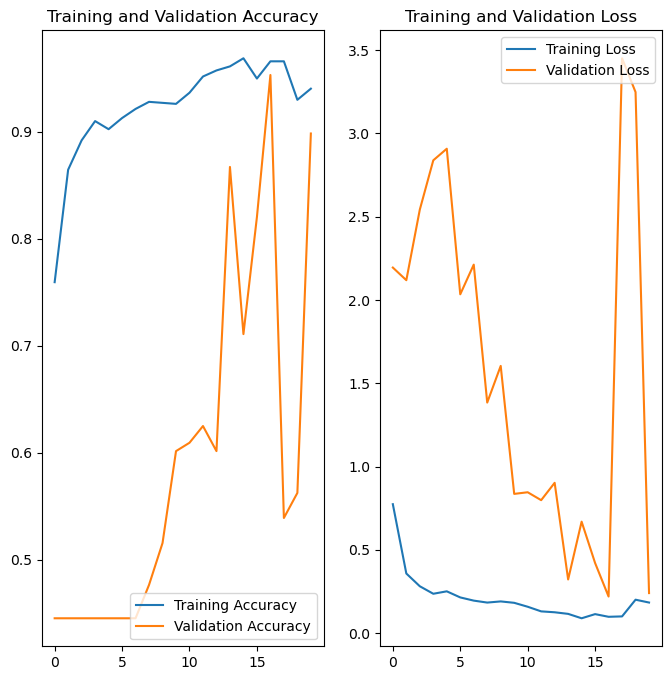

In [39]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc_02, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc_02, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss_02, label='Training Loss')
plt.plot(range(EPOCHS), val_loss_02, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [40]:
cnn_acc_02=scores_02[1]*100
print(f"Test Accuracy: ",cnn_acc_02)

Test Accuracy:  91.25000238418579


## CNN Model Architecture: 03

Used 3 layers of double Conv2d and 3 Pooling layers with Dropout Layer.

The main difference between single Conv2d and double Conv2d has more flexibility in expressing non-linear transformations without losing information. Maxpool removes information from the signal, dropout forces distributed representation, thus both effectively make it harder to propagate information. 

If a highly non-linear transformation has to be applied on raw data, stacking multiple Convs with Relu will make it easier to learn. Also model with 3 max poolings with model with only 2, consequently the second one will potentially lose less information. Another thing is it has way bigger fully connected bits at the end, while the first one is tiny with 0.25 dropout. 

This works much better than the one above in that it achieved better accuracy, lower error rate, and took many more epochs before overfitting the training data.

In [41]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model_03 = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.Conv2D(32,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(128,  kernel_size = (3,3), activation='relu'),
    layers.Conv2D(128,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Flatten(),
    
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.50),
    
    layers.Dense(n_classes, activation='softmax'),
])

model_03.build(input_shape=input_shape)

In [42]:
model_03.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_8 (Conv2D)           (32, 254, 254, 32)        896       
                                                                 
 conv2d_9 (Conv2D)           (32, 252, 252, 32)        9248      
                                                                 
 max_pooling2d_8 (MaxPooling  (32, 126, 126, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (32, 124, 124, 64)        18496     
                                                                 
 conv2d_11 (Conv2D)          (32, 122, 122, 64)        36928     
                                                      

In [43]:
model_03.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [44]:
history_03 = model_03.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=30,
)

Epoch 1/30
33/33 [==============================] - 203s 6s/step - loss: 0.9475 - accuracy: 0.6600 - val_loss: 21.4049 - val_accuracy: 0.4531
Epoch 2/30
33/33 [==============================] - 221s 7s/step - loss: 0.6811 - accuracy: 0.7377 - val_loss: 27.6190 - val_accuracy: 0.3203
Epoch 3/30
33/33 [==============================] - 249s 8s/step - loss: 0.5921 - accuracy: 0.7623 - val_loss: 7.5142 - val_accuracy: 0.5547
Epoch 4/30
33/33 [==============================] - 248s 8s/step - loss: 0.4775 - accuracy: 0.8153 - val_loss: 5.3595 - val_accuracy: 0.4922
Epoch 5/30
33/33 [==============================] - 247s 8s/step - loss: 0.4769 - accuracy: 0.8059 - val_loss: 21.3956 - val_accuracy: 0.1641
Epoch 6/30
33/33 [==============================] - 245s 7s/step - loss: 0.5036 - accuracy: 0.8002 - val_loss: 17.3462 - val_accuracy: 0.1641
Epoch 7/30
33/33 [==============================] - 248s 8s/step - loss: 0.4454 - accuracy: 0.8258 - val_loss: 18.7172 - val_accuracy: 0.1719
Epoch 8/

In [45]:
scores_03 = model_03.evaluate(test_ds) 

5/5 [==============================] - 7s 1s/step - loss: 0.4044 - accuracy: 0.8313


## Plotting the Accuracy of Model 03

In [46]:
acc_03 = history_03.history['accuracy']
val_acc_03= history_03.history['val_accuracy']

loss_03 = history_03.history['loss']
val_loss_03 = history_03.history['val_loss']


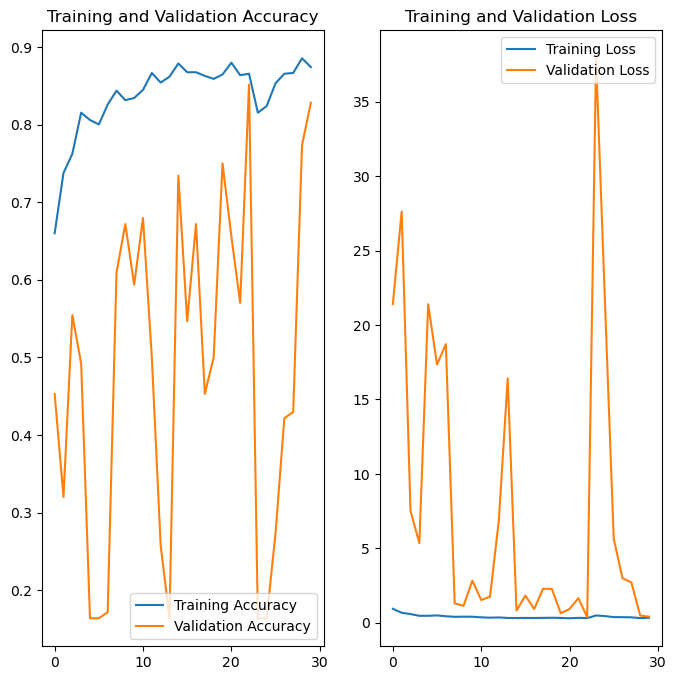

In [47]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(30), acc_03, label='Training Accuracy')
plt.plot(range(30), val_acc_03, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(30), loss_03, label='Training Loss')
plt.plot(range(30), val_loss_03, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [48]:
cnn_acc_03=scores_03[1]*100
print(f"Test Accuracy: ",cnn_acc_03)

Test Accuracy:  83.1250011920929


## Resnet50 - Model: 04

In [49]:
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.layers import Flatten
from keras.layers.core import Dense
from tensorflow.keras.optimizers import Adam

In [50]:
model_04 = Sequential()

pretrained_model= tf.keras.applications.ResNet50(include_top=False,input_shape=(256,256,3),
                                                          pooling='avg',classes=3,
                                                          weights='imagenet')
for each_layer in pretrained_model.layers:
    each_layer.trainable=False
    
model_04.add(pretrained_model)


In [51]:
model_04.add(Flatten())
model_04.add(Dense(512, activation='relu'))
model_04.add(Dense(4, activation='softmax'))

In [52]:
model_04.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_3 (Flatten)         (None, 2048)              0         
                                                                 
 dense_6 (Dense)             (None, 512)               1049088   
                                                                 
 dense_7 (Dense)             (None, 4)                 2052      
                                                                 
Total params: 24,638,852
Trainable params: 1,051,140
Non-trainable params: 23,587,712
_________________________________________________________________


In [53]:
model_04.compile(optimizer=Adam(learning_rate=0.001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [54]:
history_04 = model_04.fit(
    train_ds,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/20
33/33 [==============================] - 136s 4s/step - loss: 0.4826 - accuracy: 0.7907 - val_loss: 0.1727 - val_accuracy: 0.9297
Epoch 2/20
33/33 [==============================] - 124s 4s/step - loss: 0.1703 - accuracy: 0.9403 - val_loss: 0.2045 - val_accuracy: 0.8906
Epoch 3/20
33/33 [==============================] - 123s 4s/step - loss: 0.0991 - accuracy: 0.9621 - val_loss: 0.0687 - val_accuracy: 0.9766
Epoch 4/20
33/33 [==============================] - 123s 4s/step - loss: 0.1121 - accuracy: 0.9555 - val_loss: 0.0849 - val_accuracy: 0.9609
Epoch 5/20
33/33 [==============================] - 124s 4s/step - loss: 0.0860 - accuracy: 0.9659 - val_loss: 0.0522 - val_accuracy: 0.9844
Epoch 6/20
33/33 [==============================] - 125s 4s/step - loss: 0.0688 - accuracy: 0.9744 - val_loss: 0.1428 - val_accuracy: 0.9375
Epoch 7/20
33/33 [==============================] - 125s 4s/step - loss: 0.1054 - accuracy: 0.9640 - val_loss: 0.0325 - val_accuracy: 0.9922
Epoch 8/20
33

In [55]:
scores_04 = model_04.evaluate(test_ds)

5/5 [==============================] - 16s 3s/step - loss: 0.0716 - accuracy: 0.9812


## Plotting the Accuracy of Model 04

In [56]:
acc_04 = history_04.history['accuracy']
val_acc_04= history_04.history['val_accuracy']

loss_04 = history_04.history['loss']
val_loss_04 = history_04.history['val_loss']


In [57]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc_04, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc_04, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss_04, label='Training Loss')
plt.plot(range(EPOCHS), val_loss_04, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [58]:
res_acc_04=scores_04[1]*100
print(f"Test Accuracy: ",res_acc_04)

Test Accuracy:  98.1249988079071


## InceptionV3 Model: 05

In [59]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input

In [60]:
InceptionV3_model = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))

In [61]:
# The last 15 layers fine tune
for layer in InceptionV3_model.layers[:-15]:
    layer.trainable = False

x = InceptionV3_model.output
x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
x = Dense(units=512, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(units=512, activation='relu')(x)
x = Dropout(0.3)(x)

output  = Dense(units=4, activation='softmax')(x)
model_05 = Model(InceptionV3_model.input, output)


In [62]:
model_05.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_14 (Conv2D)             (None, 127, 127, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_6 (BatchNo  (None, 127, 127, 32  96         ['conv2d_14[0][0]']              
 rmalization)                   )                                                             

 conv2d_25 (Conv2D)             (None, 29, 29, 32)   6144        ['average_pooling2d[0][0]']      
                                                                                                  
 batch_normalization_11 (BatchN  (None, 29, 29, 64)  192         ['conv2d_19[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_13 (BatchN  (None, 29, 29, 64)  192         ['conv2d_21[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_16 (BatchN  (None, 29, 29, 96)  288         ['conv2d_24[0][0]']              
 ormalization)                                                                                    
          

                                                                                                  
 conv2d_36 (Conv2D)             (None, 29, 29, 64)   18432       ['mixed1[0][0]']                 
                                                                                                  
 batch_normalization_28 (BatchN  (None, 29, 29, 64)  192         ['conv2d_36[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_22 (Activation)     (None, 29, 29, 64)   0           ['batch_normalization_28[0][0]'] 
                                                                                                  
 conv2d_34 (Conv2D)             (None, 29, 29, 48)   13824       ['mixed1[0][0]']                 
                                                                                                  
 conv2d_37

                                                                                                  
 activation_29 (Activation)     (None, 14, 14, 96)   0           ['batch_normalization_35[0][0]'] 
                                                                                                  
 max_pooling2d_13 (MaxPooling2D  (None, 14, 14, 288)  0          ['mixed2[0][0]']                 
 )                                                                                                
                                                                                                  
 mixed3 (Concatenate)           (None, 14, 14, 768)  0           ['activation_26[0][0]',          
                                                                  'activation_29[0][0]',          
                                                                  'max_pooling2d_13[0][0]']       
                                                                                                  
 conv2d_48

 mixed4 (Concatenate)           (None, 14, 14, 768)  0           ['activation_30[0][0]',          
                                                                  'activation_33[0][0]',          
                                                                  'activation_38[0][0]',          
                                                                  'activation_39[0][0]']          
                                                                                                  
 conv2d_58 (Conv2D)             (None, 14, 14, 160)  122880      ['mixed4[0][0]']                 
                                                                                                  
 batch_normalization_50 (BatchN  (None, 14, 14, 160)  480        ['conv2d_58[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activatio

 conv2d_68 (Conv2D)             (None, 14, 14, 160)  122880      ['mixed5[0][0]']                 
                                                                                                  
 batch_normalization_60 (BatchN  (None, 14, 14, 160)  480        ['conv2d_68[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_54 (Activation)     (None, 14, 14, 160)  0           ['batch_normalization_60[0][0]'] 
                                                                                                  
 conv2d_69 (Conv2D)             (None, 14, 14, 160)  179200      ['activation_54[0][0]']          
                                                                                                  
 batch_normalization_61 (BatchN  (None, 14, 14, 160)  480        ['conv2d_69[0][0]']              
 ormalizat

 activation_64 (Activation)     (None, 14, 14, 192)  0           ['batch_normalization_70[0][0]'] 
                                                                                                  
 conv2d_79 (Conv2D)             (None, 14, 14, 192)  258048      ['activation_64[0][0]']          
                                                                                                  
 batch_normalization_71 (BatchN  (None, 14, 14, 192)  576        ['conv2d_79[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_65 (Activation)     (None, 14, 14, 192)  0           ['batch_normalization_71[0][0]'] 
                                                                                                  
 conv2d_75 (Conv2D)             (None, 14, 14, 192)  147456      ['mixed6[0][0]']                 
          

 ormalization)                                                                                    
                                                                                                  
 activation_73 (Activation)     (None, 14, 14, 192)  0           ['batch_normalization_79[0][0]'] 
                                                                                                  
 conv2d_84 (Conv2D)             (None, 14, 14, 192)  147456      ['mixed7[0][0]']                 
                                                                                                  
 conv2d_88 (Conv2D)             (None, 14, 14, 192)  258048      ['activation_73[0][0]']          
                                                                                                  
 batch_normalization_76 (BatchN  (None, 14, 14, 192)  576        ['conv2d_84[0][0]']              
 ormalization)                                                                                    
          

 ormalization)                                                                                    
                                                                                                  
 conv2d_98 (Conv2D)             (None, 6, 6, 192)    245760      ['average_pooling2d_7[0][0]']    
                                                                                                  
 batch_normalization_82 (BatchN  (None, 6, 6, 320)   960         ['conv2d_90[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_78 (Activation)     (None, 6, 6, 384)    0           ['batch_normalization_84[0][0]'] 
                                                                                                  
 activation_79 (Activation)     (None, 6, 6, 384)    0           ['batch_normalization_85[0][0]'] 
          

                                                                                                  
 activation_87 (Activation)     (None, 6, 6, 384)    0           ['batch_normalization_93[0][0]'] 
                                                                                                  
 activation_88 (Activation)     (None, 6, 6, 384)    0           ['batch_normalization_94[0][0]'] 
                                                                                                  
 activation_91 (Activation)     (None, 6, 6, 384)    0           ['batch_normalization_97[0][0]'] 
                                                                                                  
 activation_92 (Activation)     (None, 6, 6, 384)    0           ['batch_normalization_98[0][0]'] 
                                                                                                  
 batch_normalization_99 (BatchN  (None, 6, 6, 192)   576         ['conv2d_107[0][0]']             
 ormalizat

In [63]:
model_05.compile(optimizer=Adam(learning_rate=0.001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [64]:
history_05 = model_05.fit(
    train_ds,
    validation_data=val_ds,
    verbose=1,
    epochs=30,
)

Epoch 1/30
33/33 [==============================] - 98s 3s/step - loss: 2.5106 - accuracy: 0.4479 - val_loss: 1.2513 - val_accuracy: 0.5156
Epoch 2/30
33/33 [==============================] - 90s 3s/step - loss: 1.0295 - accuracy: 0.5682 - val_loss: 0.9750 - val_accuracy: 0.5078
Epoch 3/30
33/33 [==============================] - 91s 3s/step - loss: 0.8987 - accuracy: 0.6061 - val_loss: 0.8264 - val_accuracy: 0.6562
Epoch 4/30
33/33 [==============================] - 90s 3s/step - loss: 0.8135 - accuracy: 0.6581 - val_loss: 0.7910 - val_accuracy: 0.6719
Epoch 5/30
33/33 [==============================] - 90s 3s/step - loss: 0.7659 - accuracy: 0.6648 - val_loss: 0.7808 - val_accuracy: 0.7109
Epoch 6/30
33/33 [==============================] - 91s 3s/step - loss: 0.7863 - accuracy: 0.6638 - val_loss: 0.7049 - val_accuracy: 0.6797
Epoch 7/30
33/33 [==============================] - 91s 3s/step - loss: 0.7220 - accuracy: 0.6951 - val_loss: 0.7722 - val_accuracy: 0.6797
Epoch 8/30
33/33 [==

In [65]:
scores_05 = model_05.evaluate(test_ds)

5/5 [==============================] - 15s 3s/step - loss: 0.7011 - accuracy: 0.7188


## Plotting the Accuracy of Model 05

In [66]:
acc_05 = history_05.history['accuracy']
val_acc_05 = history_05.history['val_accuracy']

loss_05 = history_05.history['loss']
val_loss_05 = history_05.history['val_loss']

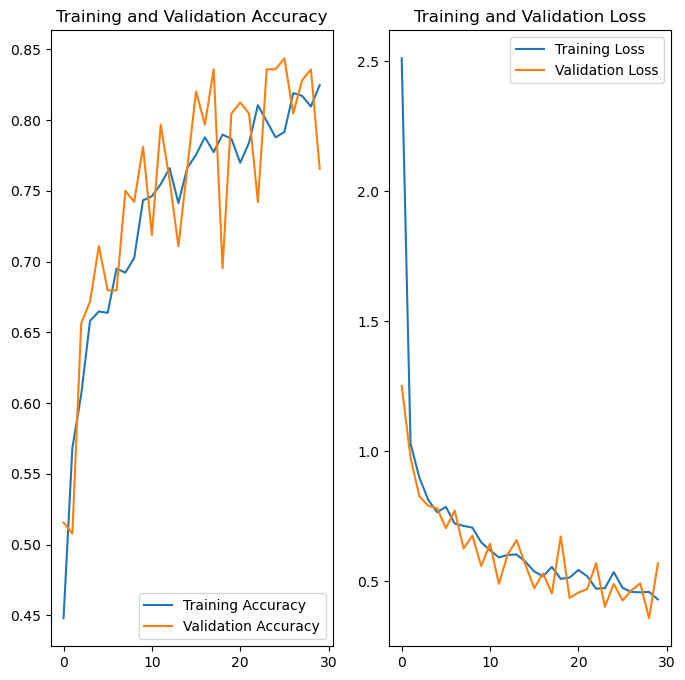

In [67]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(30), acc_05, label='Training Accuracy')
plt.plot(range(30), val_acc_05, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(30), loss_05, label='Training Loss')
plt.plot(range(30), val_loss_05, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [68]:
inc_acc_05=scores_05[1]*100
print(f"Test Accuracy: ",inc_acc_05)

Test Accuracy:  71.875


## EfficientNetB4 Model: 06

In [26]:
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.optimizers import Adam

In [27]:
efficientNetB4_model = tf.keras.applications.EfficientNetB4(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))

In [28]:
efficientNetB4_model.trainable = False

# Setup model architecture with trainable top layers
inputs = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS), name="input_layer")
x = data_augmentation(inputs) 

x = efficientNetB4_model(x, training=False)
x = layers.GlobalAveragePooling2D(name="global_avg_pool_layer")(x)



outputs = layers.Dense(4, activation="softmax", name="output_layer")(x)
model_06 = tf.keras.Model(inputs, outputs)

In [29]:
model_06.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 256, 256, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 efficientnetb4 (Functional)  (None, 8, 8, 1792)       17673823  
                                                                 
 global_avg_pool_layer (Glob  (None, 1792)             0         
 alAveragePooling2D)                                             
                                                                 
 output_layer (Dense)        (None, 4)                 7172      
                                                                 
Total params: 17,680,995
Trainable params: 7,172
Non-trainable params: 17,673,823
_____________________________________________

In [30]:
model_06.compile(optimizer=Adam(learning_rate=0.00001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [31]:
history_06 = model_06.fit(
    train_ds,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
33/33 [==============================] - 157s 4s/step - loss: 1.3242 - accuracy: 0.4091 - val_loss: 1.2918 - val_accuracy: 0.4766
Epoch 2/50
33/33 [==============================] - 133s 4s/step - loss: 1.2914 - accuracy: 0.4328 - val_loss: 1.2597 - val_accuracy: 0.5156
Epoch 3/50
33/33 [==============================] - 134s 4s/step - loss: 1.2588 - accuracy: 0.4612 - val_loss: 1.2306 - val_accuracy: 0.5312
Epoch 4/50
33/33 [==============================] - 134s 4s/step - loss: 1.2299 - accuracy: 0.4697 - val_loss: 1.2040 - val_accuracy: 0.5469
Epoch 5/50
33/33 [==============================] - 133s 4s/step - loss: 1.2129 - accuracy: 0.4669 - val_loss: 1.1795 - val_accuracy: 0.5625
Epoch 6/50
33/33 [==============================] - 133s 4s/step - loss: 1.1855 - accuracy: 0.4972 - val_loss: 1.1567 - val_accuracy: 0.5859
Epoch 7/50
33/33 [==============================] - 133s 4s/step - loss: 1.1638 - accuracy: 0.4905 - val_loss: 1.1355 - val_accuracy: 0.5938
Epoch 8/50
33

In [32]:
scores_06 = model_06.evaluate(test_ds)

5/5 [==============================] - 16s 3s/step - loss: 0.7318 - accuracy: 0.7312


## Plotting the Accuracy of Model 06

In [33]:
acc_06 = history_06.history['accuracy']
val_acc_06= history_06.history['val_accuracy']

loss_06 = history_06.history['loss']
val_loss_06 = history_06.history['val_loss']

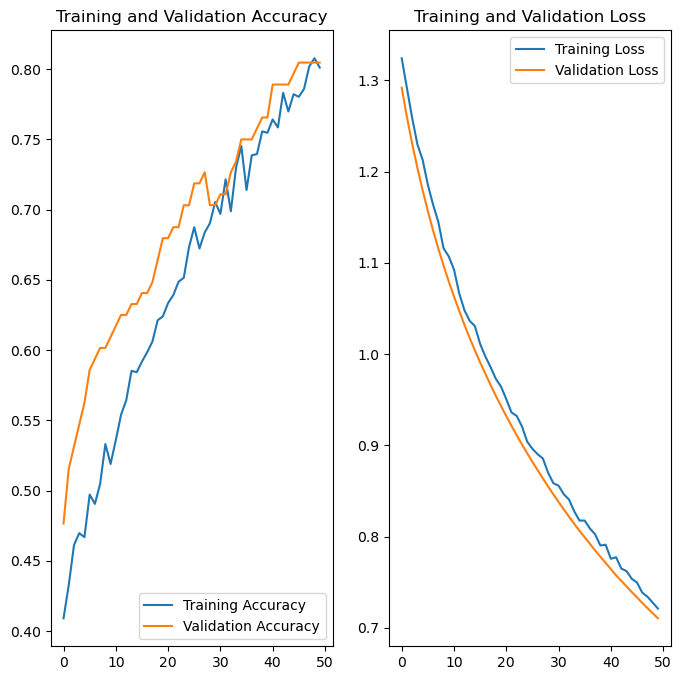

In [34]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(50), acc_06, label='Training Accuracy')
plt.plot(range(50), val_acc_06, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(50), loss_06, label='Training Loss')
plt.plot(range(50), val_loss_06, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [35]:
efn_acc_06=scores_06[1]*100
print(f"Test Accuracy: ",efn_acc_06)

Test Accuracy:  73.1249988079071


## DenseNet201: Model 07

In [69]:
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.optimizers import Adam

In [70]:
denseNet201_model = tf.keras.applications.DenseNet201(weights='imagenet', include_top=False, pooling='avg', input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))

In [71]:
denseNet201_model.trainable = False

inputs = denseNet201_model.input

drop_layer = tf.keras.layers.Dropout(0.25)(denseNet201_model.output)
x_layer = tf.keras.layers.Dense(512, activation='relu')(drop_layer)
x_layer1 = tf.keras.layers.Dense(128, activation='relu')(x_layer)
drop_layer1 = tf.keras.layers.Dropout(0.20)(x_layer1)
outputs = tf.keras.layers.Dense(4, activation='softmax')(drop_layer1)

model_07 = tf.keras.Model(inputs, outputs)

In [72]:
model_07.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 262, 262, 3)  0          ['input_3[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 128, 128, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                            

 n)                                                                                               
                                                                                                  
 conv2_block4_1_conv (Conv2D)   (None, 64, 64, 128)  20480       ['conv2_block4_0_relu[0][0]']    
                                                                                                  
 conv2_block4_1_bn (BatchNormal  (None, 64, 64, 128)  512        ['conv2_block4_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block4_1_relu (Activatio  (None, 64, 64, 128)  0          ['conv2_block4_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_blo

 conv3_block2_0_relu (Activatio  (None, 32, 32, 160)  0          ['conv3_block2_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block2_1_conv (Conv2D)   (None, 32, 32, 128)  20480       ['conv3_block2_0_relu[0][0]']    
                                                                                                  
 conv3_block2_1_bn (BatchNormal  (None, 32, 32, 128)  512        ['conv3_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_1_relu (Activatio  (None, 32, 32, 128)  0          ['conv3_block2_1_bn[0][0]']      
 n)                                                                                               
          

                                                                                                  
 conv3_block6_1_relu (Activatio  (None, 32, 32, 128)  0          ['conv3_block6_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block6_2_conv (Conv2D)   (None, 32, 32, 32)   36864       ['conv3_block6_1_relu[0][0]']    
                                                                                                  
 conv3_block6_concat (Concatena  (None, 32, 32, 320)  0          ['conv3_block5_concat[0][0]',    
 te)                                                              'conv3_block6_2_conv[0][0]']    
                                                                                                  
 conv3_block7_0_bn (BatchNormal  (None, 32, 32, 320)  1280       ['conv3_block6_concat[0][0]']    
 ization) 

 ate)                                                             'conv3_block10_2_conv[0][0]']   
                                                                                                  
 conv3_block11_0_bn (BatchNorma  (None, 32, 32, 448)  1792       ['conv3_block10_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv3_block11_0_relu (Activati  (None, 32, 32, 448)  0          ['conv3_block11_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv3_block11_1_conv (Conv2D)  (None, 32, 32, 128)  57344       ['conv3_block11_0_relu[0][0]']   
                                                                                                  
 conv3_blo

 conv4_block2_concat (Concatena  (None, 16, 16, 320)  0          ['conv4_block1_concat[0][0]',    
 te)                                                              'conv4_block2_2_conv[0][0]']    
                                                                                                  
 conv4_block3_0_bn (BatchNormal  (None, 16, 16, 320)  1280       ['conv4_block2_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block3_0_relu (Activatio  (None, 16, 16, 320)  0          ['conv4_block3_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block3_1_conv (Conv2D)   (None, 16, 16, 128)  40960       ['conv4_block3_0_relu[0][0]']    
          

 n)                                                                                               
                                                                                                  
 conv4_block7_1_conv (Conv2D)   (None, 16, 16, 128)  57344       ['conv4_block7_0_relu[0][0]']    
                                                                                                  
 conv4_block7_1_bn (BatchNormal  (None, 16, 16, 128)  512        ['conv4_block7_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block7_1_relu (Activatio  (None, 16, 16, 128)  0          ['conv4_block7_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_blo

 conv4_block11_1_relu (Activati  (None, 16, 16, 128)  0          ['conv4_block11_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block11_2_conv (Conv2D)  (None, 16, 16, 32)   36864       ['conv4_block11_1_relu[0][0]']   
                                                                                                  
 conv4_block11_concat (Concaten  (None, 16, 16, 608)  0          ['conv4_block10_concat[0][0]',   
 ate)                                                             'conv4_block11_2_conv[0][0]']   
                                                                                                  
 conv4_block12_0_bn (BatchNorma  (None, 16, 16, 608)  2432       ['conv4_block11_concat[0][0]']   
 lization)                                                                                        
          

                                                                                                  
 conv4_block16_0_bn (BatchNorma  (None, 16, 16, 736)  2944       ['conv4_block15_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block16_0_relu (Activati  (None, 16, 16, 736)  0          ['conv4_block16_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block16_1_conv (Conv2D)  (None, 16, 16, 128)  94208       ['conv4_block16_0_relu[0][0]']   
                                                                                                  
 conv4_block16_1_bn (BatchNorma  (None, 16, 16, 128)  512        ['conv4_block16_1_conv[0][0]']   
 lization)

 conv4_block20_1_conv (Conv2D)  (None, 16, 16, 128)  110592      ['conv4_block20_0_relu[0][0]']   
                                                                                                  
 conv4_block20_1_bn (BatchNorma  (None, 16, 16, 128)  512        ['conv4_block20_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block20_1_relu (Activati  (None, 16, 16, 128)  0          ['conv4_block20_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block20_2_conv (Conv2D)  (None, 16, 16, 32)   36864       ['conv4_block20_1_relu[0][0]']   
                                                                                                  
 conv4_blo

                                                                                                  
 conv4_block24_2_conv (Conv2D)  (None, 16, 16, 32)   36864       ['conv4_block24_1_relu[0][0]']   
                                                                                                  
 conv4_block24_concat (Concaten  (None, 16, 16, 1024  0          ['conv4_block23_concat[0][0]',   
 ate)                           )                                 'conv4_block24_2_conv[0][0]']   
                                                                                                  
 conv4_block25_0_bn (BatchNorma  (None, 16, 16, 1024  4096       ['conv4_block24_concat[0][0]']   
 lization)                      )                                                                 
                                                                                                  
 conv4_block25_0_relu (Activati  (None, 16, 16, 1024  0          ['conv4_block25_0_bn[0][0]']     
 on)      

 lization)                      )                                                                 
                                                                                                  
 conv4_block29_0_relu (Activati  (None, 16, 16, 1152  0          ['conv4_block29_0_bn[0][0]']     
 on)                            )                                                                 
                                                                                                  
 conv4_block29_1_conv (Conv2D)  (None, 16, 16, 128)  147456      ['conv4_block29_0_relu[0][0]']   
                                                                                                  
 conv4_block29_1_bn (BatchNorma  (None, 16, 16, 128)  512        ['conv4_block29_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_blo

 conv4_block33_1_bn (BatchNorma  (None, 16, 16, 128)  512        ['conv4_block33_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block33_1_relu (Activati  (None, 16, 16, 128)  0          ['conv4_block33_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block33_2_conv (Conv2D)  (None, 16, 16, 32)   36864       ['conv4_block33_1_relu[0][0]']   
                                                                                                  
 conv4_block33_concat (Concaten  (None, 16, 16, 1312  0          ['conv4_block32_concat[0][0]',   
 ate)                           )                                 'conv4_block33_2_conv[0][0]']   
          

                                                                                                  
 conv4_block37_concat (Concaten  (None, 16, 16, 1440  0          ['conv4_block36_concat[0][0]',   
 ate)                           )                                 'conv4_block37_2_conv[0][0]']   
                                                                                                  
 conv4_block38_0_bn (BatchNorma  (None, 16, 16, 1440  5760       ['conv4_block37_concat[0][0]']   
 lization)                      )                                                                 
                                                                                                  
 conv4_block38_0_relu (Activati  (None, 16, 16, 1440  0          ['conv4_block38_0_bn[0][0]']     
 on)                            )                                                                 
                                                                                                  
 conv4_blo

 conv4_block42_0_relu (Activati  (None, 16, 16, 1568  0          ['conv4_block42_0_bn[0][0]']     
 on)                            )                                                                 
                                                                                                  
 conv4_block42_1_conv (Conv2D)  (None, 16, 16, 128)  200704      ['conv4_block42_0_relu[0][0]']   
                                                                                                  
 conv4_block42_1_bn (BatchNorma  (None, 16, 16, 128)  512        ['conv4_block42_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block42_1_relu (Activati  (None, 16, 16, 128)  0          ['conv4_block42_1_bn[0][0]']     
 on)                                                                                              
          

                                                                                                  
 conv4_block46_1_relu (Activati  (None, 16, 16, 128)  0          ['conv4_block46_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block46_2_conv (Conv2D)  (None, 16, 16, 32)   36864       ['conv4_block46_1_relu[0][0]']   
                                                                                                  
 conv4_block46_concat (Concaten  (None, 16, 16, 1728  0          ['conv4_block45_concat[0][0]',   
 ate)                           )                                 'conv4_block46_2_conv[0][0]']   
                                                                                                  
 conv4_block47_0_bn (BatchNorma  (None, 16, 16, 1728  6912       ['conv4_block46_concat[0][0]']   
 lization)

                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 8, 8, 128)   512         ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 8, 8, 128)   0           ['conv5_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block2_2_conv (Conv2D)   (None, 8, 8, 32)     36864       ['conv5_block2_1_relu[0][0]']    
                                                                                                  
 conv5_block2_concat (Concatena  (None, 8, 8, 960)   0           ['conv5_block1_concat[0][0]',    
 te)      

 conv5_block6_2_conv (Conv2D)   (None, 8, 8, 32)     36864       ['conv5_block6_1_relu[0][0]']    
                                                                                                  
 conv5_block6_concat (Concatena  (None, 8, 8, 1088)  0           ['conv5_block5_concat[0][0]',    
 te)                                                              'conv5_block6_2_conv[0][0]']    
                                                                                                  
 conv5_block7_0_bn (BatchNormal  (None, 8, 8, 1088)  4352        ['conv5_block6_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block7_0_relu (Activatio  (None, 8, 8, 1088)  0           ['conv5_block7_0_bn[0][0]']      
 n)                                                                                               
          

                                                                                                  
 conv5_block11_0_relu (Activati  (None, 8, 8, 1216)  0           ['conv5_block11_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block11_1_conv (Conv2D)  (None, 8, 8, 128)    155648      ['conv5_block11_0_relu[0][0]']   
                                                                                                  
 conv5_block11_1_bn (BatchNorma  (None, 8, 8, 128)   512         ['conv5_block11_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block11_1_relu (Activati  (None, 8, 8, 128)   0           ['conv5_block11_1_bn[0][0]']     
 on)      

 lization)                                                                                        
                                                                                                  
 conv5_block15_1_relu (Activati  (None, 8, 8, 128)   0           ['conv5_block15_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block15_2_conv (Conv2D)  (None, 8, 8, 32)     36864       ['conv5_block15_1_relu[0][0]']   
                                                                                                  
 conv5_block15_concat (Concaten  (None, 8, 8, 1376)  0           ['conv5_block14_concat[0][0]',   
 ate)                                                             'conv5_block15_2_conv[0][0]']   
                                                                                                  
 conv5_blo

 conv5_block19_concat (Concaten  (None, 8, 8, 1504)  0           ['conv5_block18_concat[0][0]',   
 ate)                                                             'conv5_block19_2_conv[0][0]']   
                                                                                                  
 conv5_block20_0_bn (BatchNorma  (None, 8, 8, 1504)  6016        ['conv5_block19_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block20_0_relu (Activati  (None, 8, 8, 1504)  0           ['conv5_block20_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block20_1_conv (Conv2D)  (None, 8, 8, 128)    192512      ['conv5_block20_0_relu[0][0]']   
          

 on)                                                                                              
                                                                                                  
 conv5_block24_1_conv (Conv2D)  (None, 8, 8, 128)    208896      ['conv5_block24_0_relu[0][0]']   
                                                                                                  
 conv5_block24_1_bn (BatchNorma  (None, 8, 8, 128)   512         ['conv5_block24_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block24_1_relu (Activati  (None, 8, 8, 128)   0           ['conv5_block24_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_blo

 conv5_block28_1_relu (Activati  (None, 8, 8, 128)   0           ['conv5_block28_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block28_2_conv (Conv2D)  (None, 8, 8, 32)     36864       ['conv5_block28_1_relu[0][0]']   
                                                                                                  
 conv5_block28_concat (Concaten  (None, 8, 8, 1792)  0           ['conv5_block27_concat[0][0]',   
 ate)                                                             'conv5_block28_2_conv[0][0]']   
                                                                                                  
 conv5_block29_0_bn (BatchNorma  (None, 8, 8, 1792)  7168        ['conv5_block28_concat[0][0]']   
 lization)                                                                                        
          

                                                                                                  
 bn (BatchNormalization)        (None, 8, 8, 1920)   7680        ['conv5_block32_concat[0][0]']   
                                                                                                  
 relu (Activation)              (None, 8, 8, 1920)   0           ['bn[0][0]']                     
                                                                                                  
 avg_pool (GlobalAveragePooling  (None, 1920)        0           ['relu[0][0]']                   
 2D)                                                                                              
                                                                                                  
 dropout_4 (Dropout)            (None, 1920)         0           ['avg_pool[0][0]']               
                                                                                                  
 dense_11 

In [73]:
model_07.compile(optimizer=Adam(learning_rate=0.00001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [74]:
history_07 = model_07.fit(
    train_ds,
    validation_data=val_ds,
    verbose=1,
    epochs=30,
)

Epoch 1/30
33/33 [==============================] - 191s 5s/step - loss: 4.1502 - accuracy: 0.2453 - val_loss: 2.3293 - val_accuracy: 0.2969
Epoch 2/30
33/33 [==============================] - 164s 5s/step - loss: 2.5547 - accuracy: 0.3258 - val_loss: 1.7674 - val_accuracy: 0.3125
Epoch 3/30
33/33 [==============================] - 164s 5s/step - loss: 2.1233 - accuracy: 0.3617 - val_loss: 1.6100 - val_accuracy: 0.3594
Epoch 4/30
33/33 [==============================] - 165s 5s/step - loss: 1.9421 - accuracy: 0.3987 - val_loss: 1.4801 - val_accuracy: 0.4453
Epoch 5/30
33/33 [==============================] - 164s 5s/step - loss: 1.8125 - accuracy: 0.4157 - val_loss: 1.3703 - val_accuracy: 0.4375
Epoch 6/30
33/33 [==============================] - 164s 5s/step - loss: 1.7658 - accuracy: 0.4148 - val_loss: 1.2699 - val_accuracy: 0.4531
Epoch 7/30
33/33 [==============================] - 164s 5s/step - loss: 1.5697 - accuracy: 0.4602 - val_loss: 1.1540 - val_accuracy: 0.5000
Epoch 8/30
33

In [75]:
scores_07 = model_07.evaluate(test_ds)

5/5 [==============================] - 22s 4s/step - loss: 0.6740 - accuracy: 0.7250


## Plotting the Accuracy of Model 07

In [76]:
acc_07 = history_07.history['accuracy']
val_acc_07= history_07.history['val_accuracy']

loss_07 = history_07.history['loss']
val_loss_07 = history_07.history['val_loss']

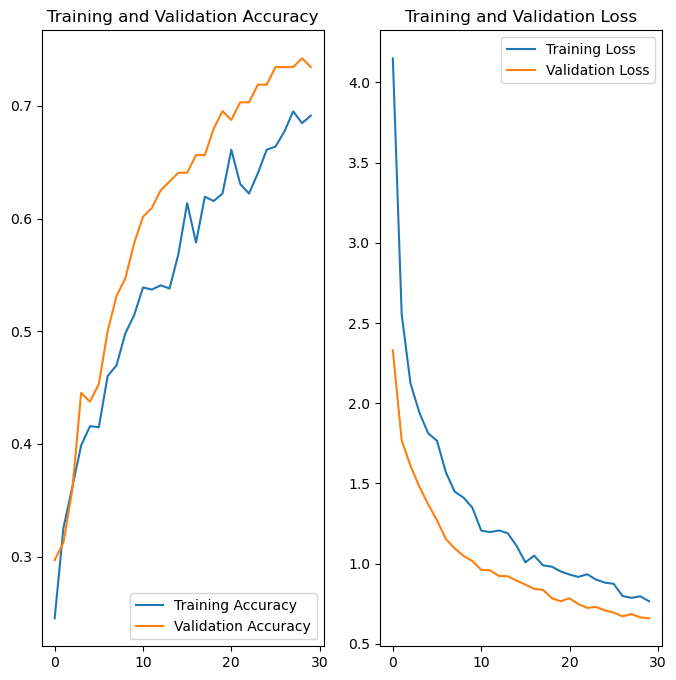

In [77]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(30), acc_07, label='Training Accuracy')
plt.plot(range(30), val_acc_07, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(30), loss_07, label='Training Loss')
plt.plot(range(30), val_loss_07, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [79]:
den_acc_07=scores_07[1]*100
print(f"Test Accuracy: ",efn_acc_07)

Test Accuracy:  72.50000238418579


In [82]:
efn_acc_06=73.12

## Accuracy Comparison Plot Between Proposed And Transfer Learning Models

In [83]:
import pandas as pd
import seaborn as sns

df = pd.DataFrame(data=
{'Deep Learning Model':['CNN Arch-01','CNN Arch-02','CNN Arch-03','ResNet50','InceptionV3','EfficientNetB4', 'DenseNet201'],
'Accuracy':[cnn_acc_01, cnn_acc_02, cnn_acc_03, res_acc_04, inc_acc_05, efn_acc_06, den_acc_07]})

plt.figure(figsize=(9,6))

p = sns.barplot(x='Deep Learning Model', y='Accuracy',data=df)
for i in p.containers:
    labels = [f'{v.get_height():0.02f}%' for v in i]
    p.bar_label(i, labels=labels)

##  Run Prediction With CNN Architecture -02 on a sample image

first image to predict
actual label: Healthy
1/1 [==============================] - 10s 10s/step
predicted label: Healthy


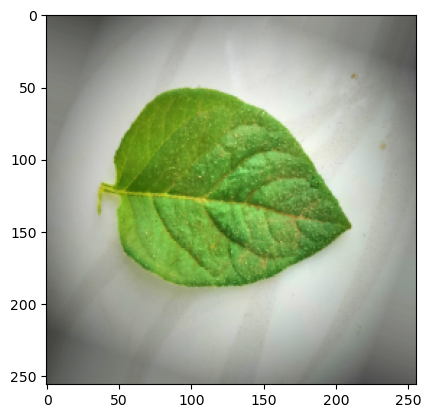

In [84]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model_04.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [85]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model_04.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 243ms/step


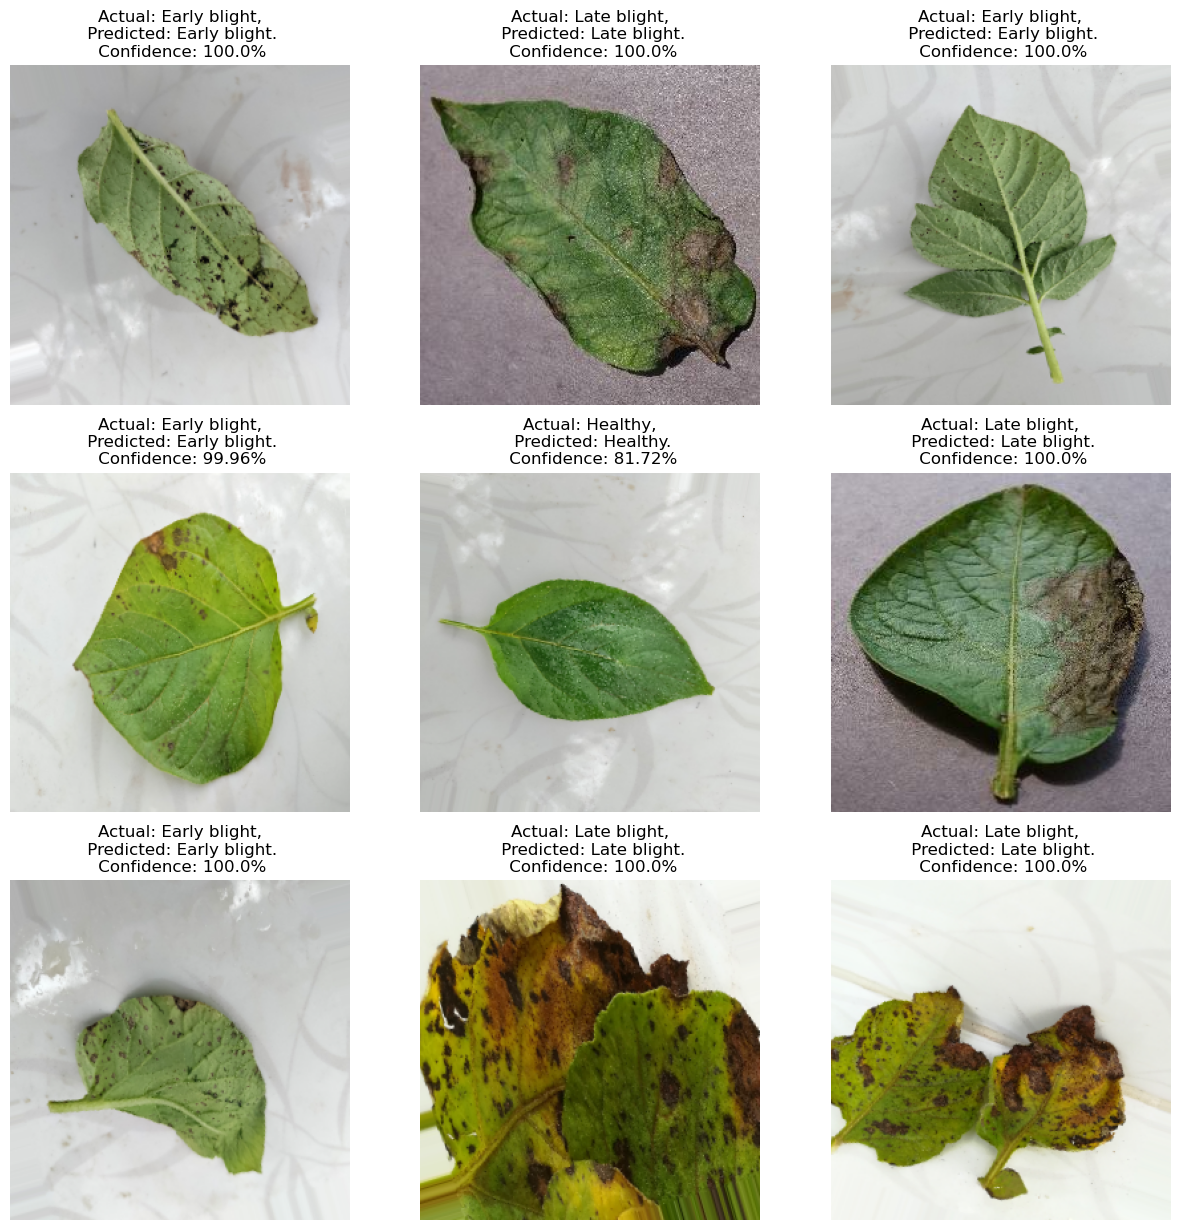

In [86]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model_04, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")